In [1]:
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import astropy.units as u
import splat.empirical as spe
import splat
#plt.style.use('dark_background')

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database












Purpose: compare various luminosity functions

In [2]:
%matplotlib inline

In [3]:
baraffe=wispsim.make_systems(model_name='baraffe2003', bfraction=0.2)
saumon=wispsim.make_systems(model_name='saumon2008', bfraction=0.2)
sonora=wispsim.make_systems(model_name='marley2019', bfraction=0.2)
phillips=wispsim.make_systems(model_name='phillips2020', bfraction=0.2)

In [4]:
from astropy.io import ascii

In [5]:
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
dntb=ascii.read('/users/caganze/research/wisps/data/daniellalf.txt').to_pandas()

In [6]:
def splat_mag_to_spt(mag):
    grid=np.arange(17, 39)
    rel=spe.typeToMag(grid, 'MKO_J',reference='dupuy2012')[0]
    vals= np.polyval(rel, grid)
    spt_sorted_idx=np.argsort(vals)
    return np.interp(mag, vals[spt_sorted_idx], grid[spt_sorted_idx])
       

In [7]:
klf['tfm']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)

In [8]:
klf['spt']=klf.tfm.apply(wispsim.splat_teff_to_spt).apply(round)

In [9]:
klf=klf.applymap(float)

In [10]:
dntb['spt']=dntb.M_J.apply(splat_mag_to_spt)

In [11]:
def ryan_lf(J):
    logphi=-0.30 + 0.11*(J-14) + 0.15*(J -14)**2.+ 0.015*(J-14)**3-0.00020*(J-14)**4
    return (10**logphi)*(10**-3)

    
def custom_histogram(things, grid, binsize):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+binsize)]))
    return np.array(n)

In [12]:
jgrid=np.arange(10, 18, .5)
teffgrid=np.arange(50, 4000, 150)

In [13]:
#the last point is a lower limit
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [14]:
525-450

75

In [15]:
(kirkpatrick2020LF['unc']/kirkpatrick2020LF['values']).mean()

0.21262705367610932

In [16]:
def scale_lf_teff(teffs):
    #dont fit the last bin
    bins= np.array(kirkpatrick2020LF['bin_center'])
    binedges= np.append(bins-75,bins[-1]-75)

    bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    preds=np.histogram(teffs, bins=binedges, normed=True)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    scale=np.nansum((obs*preds)/(unc**2))/np.nansum(((preds**2)/(unc**2)))
    return preds*scale

In [17]:
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

In [18]:
teffs_bar=baraffe['system_teff']
teffs_saumon=saumon['system_teff']
teffs_sonora=sonora['system_teff']
teffs_phil=phillips['system_teff']

#normteff_bar = 0.63*(10**-3)/ len(teffs_bar[np.logical_and(teffs_bar>=1650, teffs_bar <=1800)])
#normteff_saumon = 0.63*(10**-3)/ len(teffs_saumon[np.logical_and(teffs_saumon>=1650, teffs_saumon <=1800)])
#normteff_sonora= 0.63*(10**-3)/ len(teffs_sonora[np.logical_and(teffs_sonora>=1650, teffs_sonora <=1800)])
#normteff_phil=0.63*(10**-3)/ len(teffs_phil[np.logical_and(teffs_phil>=1650, teffs_phil <=1800)])
#jmags=wisps.drop_nan(spe.typeToMag(SIMULATED_DIST['spts'][0], '2MASS J')[0])
#jnorm=6.570*(10**-3)/len(jmags[np.logical_and(jmags>=10.25-.25, jmags <=10.25+.25)])

In [19]:
#sem_emp_phi_j=custom_histogram(jmags, jgrid, .5)*jnorm
baraffe_phi_teff= scale_lf_teff(teffs_bar)*(10**-3)
saumon_phi_teff=scale_lf_teff(teffs_saumon)*(10**-3)
sonora_phi_teff=scale_lf_teff(teffs_sonora)*(10**-3)
phil_phi_teff=scale_lf_teff(teffs_phil)*(10**-3)

In [20]:
sonora_phi_teff/phil_phi_teff

array([1.01083901, 1.04807718, 1.01167015, 0.95092916, 0.91065343,
       0.94982992, 1.01827531, 1.01919013, 1.08973531, 1.16180274,
              nan])

In [21]:
#count how many things are in the masses of 0.1 and stuff and compare to 0.005 pc to 0.0037 pc^3

#2 things doing this 

#teff-> bolometric correction -> simulated luminosity ---> magnitude

#try will best's 2018 relation 
#and that we dont't complete samples for some magnitudes 
#compare to bochanski's measurement
#look at the scale factors between those two plots you might you want

#you should be plotting the fits that are 
#invert relations

#invert

#binary fraction (how many)
#binary fraction random 20% 
#binary mass ratio from a distribution from splat (allen et al. from splat)
#the secondary have a magnitude 
#the bianay 
#mag of the system by combining the flux
#hst magnitude of the secondary by adding the 
#adding the
#everything is laid out in burgasser 2007
#educational exercise to find thre number of stars and brown dwarfs


In [22]:
import seaborn as sns
sns.set_palette(sns.color_palette('Paired'))

[1 0 0 0 0 0 0 0 0 0 0]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


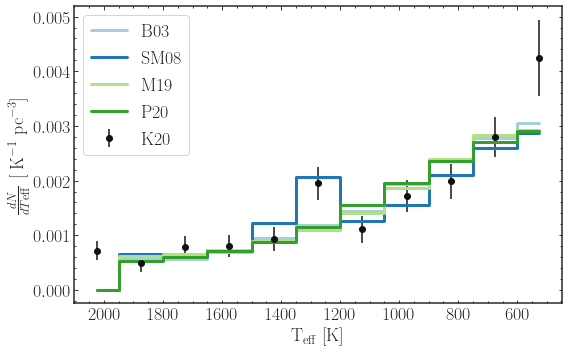

In [23]:
fig, ax1=plt.subplots(figsize=(8, 5), ncols=1)
#ax.step(jgrid, sem_emp_phi_j, color='#0074D9', label='Simulated')
#ax.step(jgrid,  ryan_lf(jgrid), color='#FF4136', label='RyanJr2017')
#ax.errorbar(dntb.M_J, dntb.Density*(10**-3), fmt='o', c='k', label='BG2019')

#ax.set_xlabel('J', fontsize=18)
#ax.set_ylabel(r'LF [pc$^{-3}$ mag$^{-1} $]', fontsize=18)
#ax.minorticks_on()
#ax.legend(fontsize=18)
#ax.set_xlim([10, 16])
#ax.set_ylim([0., 0.005])

ax1.step(kirkpatrick2020LF['bin_center'], baraffe_phi_teff,  where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], saumon_phi_teff, where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], sonora_phi_teff, where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], phil_phi_teff,  where='mid', linewidth=3)
lolims=np.zeros(len(kirkpatrick2020LF['bin_center'])).astype(int)
lolims[0]=int(1)

print (lolims)
ax1.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
             yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3),
             fmt='o', color='#111111')

#for index, row in klf.iterrows():
#    if row.lf==0.0:
#        pass
#    elif row.lfunc==0.0:
#        ax1.errorbar(row.tfm,  row.lf*(10**-3), yerr=0.0005, color='#B10DC9', fmt='o',lolims=True, ls='none')
#    else:
#        ax1.errorbar(row.tfm,  row.lf*(10**-3),  yerr=row.lfunc*(10**-3), color='#B10DC9', fmt='o')
ax1.set_xlabel(r'T$_\mathrm{eff}$ [K]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dT\mathrm{eff}}$ [ K$^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=['B03',  'SM08',  'M19',  'P20',  'K20'])
ax1.set_xlim([2100, 450.])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_teffs.pdf',  bbox_inches='tight')

In [24]:
js_saumon=wisps.absolute_magnitude_jh(np.sort(saumon['system_spts'].flatten()))[0]
js_bar=wisps.absolute_magnitude_jh(np.sort( baraffe['system_spts'].flatten()))[0]
js_sonora=wisps.absolute_magnitude_jh(np.sort( sonora['system_spts'].flatten()))[0]
js_phil=wisps.absolute_magnitude_jh(np.sort( phillips['system_spts'].flatten()))[0]

In [25]:
CRUZ={"J":np.array([10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75]),
      "lf": np.array([2.38, 1.66, 1.16, 0.83, 0.50, 0.58, 0.50, 0.66, 0.33]),
     'er':np.array([0.64, 0.37, 0.31, 0.26, 0.20, 0.22, 0.20, 0.23, 0.17])}

DNLF={"J": dntb.M_J.values, 'lf': dntb.Density.values, 
     "er":[[1.39, 0.39, 0.29, 0.20, 0.18, 0.15, 0.41, 0.16, 0.15], 
           [1.62, 4.14, 0.31, 0.23, 0.20, 0.18, 1.65, 0.18, 0.18]]}

In [26]:
DNLF

{'J': array([ 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75]),
 'lf': array([0.928, 6.57 , 3.62 , 1.9  , 1.5  , 1.1  , 0.94 , 1.21 , 1.1  ]),
 'er': [[1.39, 0.39, 0.29, 0.2, 0.18, 0.15, 0.41, 0.16, 0.15],
  [1.62, 4.14, 0.31, 0.23, 0.2, 0.18, 1.65, 0.18, 0.18]]}

In [27]:
mask=np.logical_and(CRUZ['J'] <= 15.5, CRUZ['J'] >= 10.)
def scale_lf_jmag(js):
    #mask=np.logical_and(DNLF['J'] <= 15.5, DNLF['J'] >= 10.)
    jgrid=np.array(CRUZ['J'])[mask]
    print (len(jgrid))
    obs=np.array(DNLF['lf'])[mask]
    #unc=np.nanmean(np.array(CRUZ['er']), axis=0)[mask]
    unc=np.array(CRUZ['er'])
    
    binedges= np.append(jgrid-0.25, jgrid[-1]+0.5)
    bools=np.logical_and(js <= binedges[-1], js >= binedges[0])
    preds=np.histogram(js, bins=binedges, normed=True)[0]

    scale=np.nansum((obs*preds)/(unc**2))/np.nansum(((preds**2)/(unc**2)))
    return preds*scale

In [28]:
baraffe_phi_j=scale_lf_jmag(js_bar)*(10**-3)
saumon_phi_j=scale_lf_jmag(js_saumon)*(10**-3)
sonora_phi_j=scale_lf_jmag(js_sonora)*(10**-3)
phil_phi_j=scale_lf_jmag(js_phil)*(10**-3)

9
9
9
9


In [29]:
#len(phil_phi_j)

In [30]:
#DNLF['J'][bools]

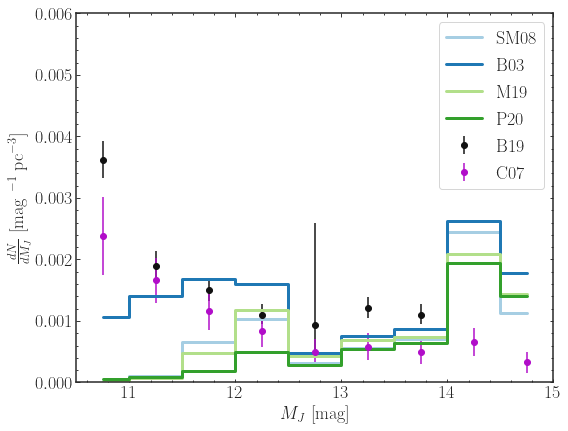

In [31]:
fig, ax1=plt.subplots(figsize=(8, 6), ncols=1)
#plt.step(jgrid, ryan_lf(jgrid))
plt.step(np.array(CRUZ['J'])[mask], saumon_phi_j, linewidth=3, where='mid')
plt.step(np.array(CRUZ['J'])[mask], baraffe_phi_j, linewidth=3, where='mid')
plt.step(np.array(CRUZ['J'])[mask], sonora_phi_j, linewidth=3, where='mid')
plt.step(np.array(CRUZ['J'])[mask],phil_phi_j, linewidth=3, where='mid')

#plt.fill_between(jgrid, np.array(baraffe_phi_j)-0.00016, np.array(baraffe_phi_j)+0.00018,  step="pre")

plt.errorbar(DNLF['J'], DNLF['lf']*0.001, yerr=np.array(DNLF['er'])*0.001,color='#111111', fmt='o')
plt.errorbar(CRUZ['J'], np.array(CRUZ['lf'])*0.001, yerr=np.array(CRUZ['er'])*0.001,color='#B10DC9', fmt='o')


ax1.set_xlabel(r'$M_J$ [mag]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dM_J}$ [mag $^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=[ 'SM08', 'B03', 'M19', 'P20', 'B19', 
                               'C07'])
plt.tight_layout()
plt.xlim(10.5, 15.)
plt.ylim([0.00, 0.006])
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_js.pdf',  bbox_inches='tight')

In [53]:
df=pd.read_pickle(wisps.OUTPUT_FILES+'/effective_numbers_from_sims')

In [55]:
len(df['phillips2020']['spts'])

538553

In [60]:
len(df['phillips2020'][200]['sl'])

538485

In [61]:
len(df['phillips2020'][200]['snrj'])

538485

In [34]:
ghjnkD

KeyError: 'r'

In [ ]:
#save the inertpolated luminosity function
LF={}

In [ ]:
for modname in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    
    vals=wispsim.make_systems(model_name=modname, bfraction=0.2)
    teffs_bar=vals['system_teff']
    sys_spts=vals['system_spts']
    
    normteff_bar = 0.63*(10**-3)/ len(teffs_bar[np.logical_and(teffs_bar>=1650, teffs_bar <=1800)])
    #normspt
    normspt=   ((1650-1800)/(24.57-25.77))*0.63*(10**-3)/len(sys_spts[np.logical_and( sys_spts>=24.58,  sys_spts <=25.77)])
            
    spt_grid=wisps.splat_teff_to_spt(teffgrid)
   
    phi_spt=custom_histogram(sys_spts, spt_grid, 1)*normspt
    LF[modname]={'spt':spt_grid, 'phi':phi_spt}

In [ ]:
#import pickle
#with open(wisps.OUTPUT_FILES+'/lf.pkl', 'wb') as file:
#   pickle.dump(LF,file)

In [ ]:
drf
h=wispsim.make_systems(bfraction=0.99, nsample=1e6,  recompute=False)
h0=wispsim.make_systems(bfraction=0.01, nsample=1e6,  recompute=False)

In [ ]:
plt.plot(h['system_age'])

In [ ]:
plt.scatter(h['system_spts'], h['system_teff'], s=1)

In [ ]:
plt.hist(h['system_spts'], density=True, bins=32)
plt.hist(h0['system_spts'], density=True, bins=32)